In [39]:
import re
import math

import pandas as pd 
import numpy as np 
import seaborn as sns 

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout 
from keras.layers import LSTM
from keras.layers import SimpleRNN

from keras import regularizers
from keras.activations import relu, sigmoid
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model


from scipy import stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
pd.set_option('max_columns', None)
pd.set_option('display.float_format', str)
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [9,5]
plt.rcParams["axes.edgecolor"] = "black"

# Deep Learning Model Selection

#### Check if GPU exists

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()
!python --version

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5193076083477409622
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 770679133906726897
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7052715648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16612348361761671312
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:06:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15526364616269155587
physical_device_desc: "device: XLA_GPU device"
]
2.2.0
Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Python 3.6.13 :: Anaconda, Inc.


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Create Helper function

In [68]:
def evaluate_and_plot(model,y_val,y_pred):
    '''
    This function improves QOL for the programmer 
    by allowing to run tests fast without writing code over and over,
    to evaluate a models performance.
    
    '''
    y_pred = y_pred.ravel()
    te_y = np.array(y_val)
    
    # Extract name from model __class__
    model_name = re.findall(r'(?<=\.)[a-zA-Z]+(?=\')',str(model.__class__))[0]
    
    # extract line of best fit statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(te_y,y_pred)
    
    NRMSE = (mean_squared_error(te_y, y_pred, squared = 0))/(te_y.std())
    R2 = r2_score(te_y, y_pred)
    
    # Print out results
    print(f'Regression Metrics')
    print(f'NRMSE = {NRMSE:.2f} AED')
    print(f'R^2 = {R2:.2f}')
    
    print('\nLinregress Metrics')
    print(f'r = {r_value:.2f}, p = {p_value:.2f}, err = {std_err:.2f}')
    
    # Plot Loss
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Learning Curve')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

    # plot A vs. P plot with regression line
    sns.regplot(x = te_y, y = y_pred, line_kws = {'label': f' y = {slope:.1f} x + {intercept:.1f}'})
    plt.legend()
    plt.title(f'A v P Plot')
    plt.xlabel('Actual Price (AED)')
    plt.ylabel('Predicted Price (AED)')
    plt.show()

### Training Data

In [5]:
df = pd.read_csv('datasets/training/train_normlog.csv')
df.head()

,number,price,num_digits,unique_digits,num_zeros,max_group,max_group_second,shan_entrop,lv_dist,num_ones,num_twos,num_threes,num_fours,num_fives,num_sixes,num_sevens,num_eights,num_nines,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.012518888410771648,11.599112335481124,0.6666666666666666,0.25,0.0,0.25,0.25,0.43067655807339295,0.14123711340206135,0.4,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.031622451940878024,11.184435286790633,0.6666666666666666,0.25,0.0,0.5,0.0,0.3493984702822971,0.5324742268041227,0.0,0.75,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2999229452911567,10.085850775128716,1.0,0.25,0.5,0.5,0.25,0.4181656600790517,0.7855670103092773,0.0,0.0,0.6000000000000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.07708473015841248,9.770013301136158,0.6666666666666666,0.5,0.0,0.25,0.0,0.6460148371100896,0.22989690721649406,0.0,0.0,0.0,0.0,0.25,0.25,0.6666666666666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.08820262386294267,9.770013301136158,0.6666666666666666,0.5,0.0,0.25,0.0,0.6460148371100896,0.28608247422680394,0.0,0.0,0.0,0.0,0.0,0.25,0.3333333333333333,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
# Target column
y = df['price']

# Feature columns and matrix
features = [col for col in df.columns if col not in ('price','price_per_sqft')]
X = df[features]

# Create the test train split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.2)

# Features shape
n_features = train_X.shape[1]

## Model Selection

### DNN

In [27]:
# Test with a genetic DNN
model = Sequential([
    Dense(n_features, activation='relu', kernel_regularizer = regularizers.l2(0.01), input_shape=(n_features,)),
        Dropout(0.2),
    Dense(n_features, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
        Dropout(0.2),
    Dense(n_features, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
        Dropout(0.2),
    Dense(n_features, activation='relu', kernel_regularizer = regularizers.l2(0.01)),
        Dropout(0.2),
    Dense(1, activation = 'relu', kernel_regularizer = regularizers.l2(1)),
])

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'mse')

In [28]:
hist = model.fit(x = train_X,
                 y = train_y,
                 batch_size = 512,
                 epochs = 150,
                 validation_data = (val_X, val_y),
                verbose = 0)

#### Check metrics

Regression Metrics
NRMSE = 0.50 AED
R^2 = 0.75

Linregress Metrics
r = 0.90, p = 0.00, err = 0.01


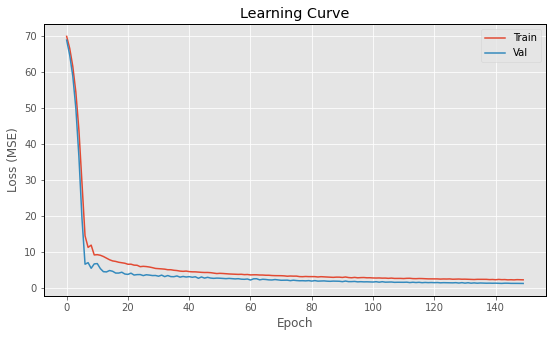

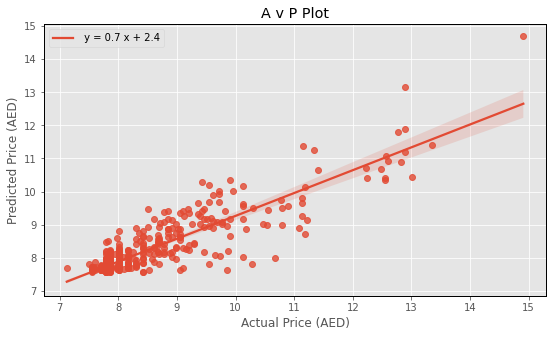

In [29]:
y_pred = model.predict(val_X)
evaluate_and_plot(hist,val_y,y_pred, plot = 1)

## RNN

### Check if plate numbers can be modelled as a pseudo-timeseries

<AxesSubplot:xlabel='number', ylabel='price'>

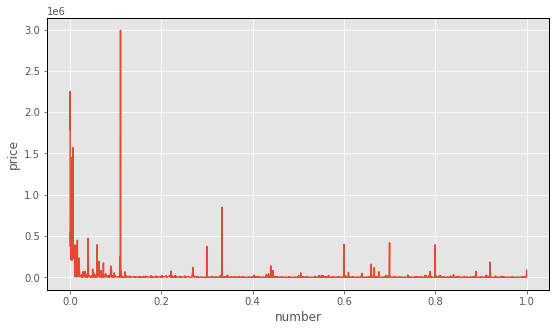

In [43]:
sns.lineplot(data = df, x = 'number', y = np.expm1(df['price']))

Wil try just using a number to price, no feature extraction model

In [117]:
# Data 
t = df[[col for col in df.columns if col != 'price']].to_numpy()
x = df['price'].to_numpy()

dft = pd.DataFrame(x)

In [154]:
# Reshaping for test train and window size
step = 400           # Window size
Tp = int(t.shape[0]*0.2)  # 20% of training data is test percentage
N = t.shape[0]       # Testing samples

# Test train split
values = df.values
train,test = values[0:Tp,:], values[Tp:N,:]

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

# convert into dataset matrix
# with sliding windows
def convertToMatrix(data, step):
    X, Y = [], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

In [155]:
# Reshape such that it fits into RNN
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [159]:
model = Sequential([
    SimpleRNN(units = 256, input_shape = (1,step), activation = "relu"),
    Dense(128, activation = "relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(1, activation = 'relu', kernel_regularizer = regularizers.l2(1))
])

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 256)               168192    
_________________________________________________________________
dense_77 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 129       
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
_________________________________________________________________


In [160]:
hist = model.fit(trainX,
                 trainY,
                 epochs = 200,
                 batch_size = 1024,
                 validation_data = (testX, testY),
                 verbose = 0)

Regression Metrics
NRMSE = 0.14 AED
R^2 = 0.98

Linregress Metrics
r = 0.99, p = 0.00, err = 0.00


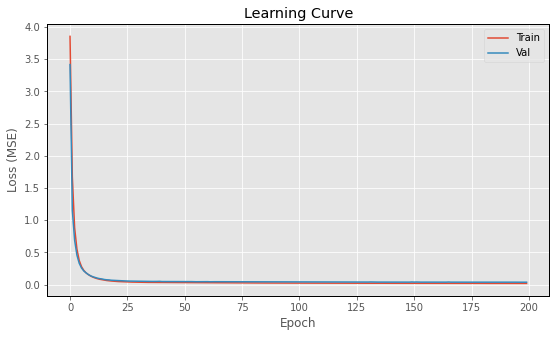

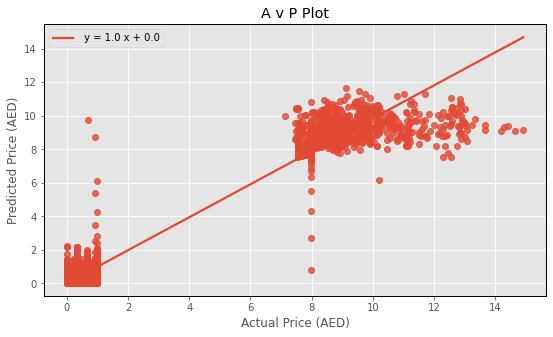

In [161]:
evaluate_and_plot(hist,testY,model.predict(testX))